In [154]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import glob
from tqdm import tqdm
from sklearn.utils import shuffle
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer


def get_N_matrix(topic, verbose=True, drop_subsumed=True):
    MEDIA = ['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']
    cv = CountVectorizer(max_df=0.9, min_df=10, max_features=10000, ngram_range=(1,3))

    df = pd.read_csv('../data/sorted/'+topic+'.csv', index_col=0)
    cv.fit(df['preprocessed'])

    df['preprocessed'] = df['preprocessed'] + ' '
    df = df[['medium', 'preprocessed', 'dominant topic']]
    df_grouped = df.groupby(['medium', 'dominant topic']).sum()

    df = pd.DataFrame(index=MEDIA, columns=['preprocessed'])
    for medium in MEDIA:
        df.loc[medium] = df_grouped.loc[medium].loc[topic]['preprocessed']

    
    N_matrix = cv.transform(df['preprocessed'].values)

    N_df = pd.DataFrame(data=N_matrix.toarray().transpose(),
                        columns=df.index,
                        index=cv.get_feature_names_out())

    if drop_subsumed:
        N_df = N_df.reset_index().rename(columns={'index':'phrase'})
        N_df['n_gram'] = N_df['phrase'].apply(str.split).apply(len)
        N_df['count'] = N_df[['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']].sum(axis=1)

        monograms = N_df[N_df['n_gram'] == 1]
        bigrams = N_df[N_df['n_gram'] == 2]
        trigrams = N_df[N_df['n_gram'] == 3]

        bigram_words = list(set([word for bigram_sublist in bigrams['phrase'].apply(str.split).tolist() for word in bigram_sublist]))
        trigram_words = list(set([word for trigram_sublist in trigrams['phrase'].apply(str.split).tolist() for word in trigram_sublist]))

        monograms_in_bigrams = monograms[monograms['phrase'].isin(bigram_words)]
        monograms_in_trigrams = monograms[monograms['phrase'].isin(trigram_words)]

        bigrams_in_trigrams_words = list(set([bigram_word for bigram_word in bigram_words if bigram_word in trigram_words]))
        bigrams_in_trigrams_mask = bigrams['phrase'].apply(lambda bigram: True if bigram.split()[0] in bigrams_in_trigrams_words or bigram.split()[1] in bigrams_in_trigrams_words else False)
        bigrams_in_trigrams = bigrams[bigrams_in_trigrams_mask]

        threshold = 0.7
        monograms_in_bigrams_above_threshold = list(set([monogram['phrase'] for _, monogram in monograms_in_bigrams.iterrows() for _, bigram in bigrams.iterrows() if monogram['phrase'] in bigram['phrase'].split() and bigram['count'] > threshold*monogram['count']]))
        monograms_in_trigrams_above_threshold = list(set([monogram['phrase'] for _, monogram in monograms_in_trigrams.iterrows() for _, trigram in trigrams.iterrows() if monogram['phrase'] in trigram['phrase'].split() and trigram['count'] > threshold*monogram['count']]))
        bigrams_in_trigrams_above_threshold = list(set([bigram['phrase'] for _, bigram in bigrams_in_trigrams.iterrows() for _, trigram in trigrams.iterrows() if (bigram['phrase'] in " ".join(trigram['phrase'].split()[:2]) or bigram['phrase'] in " ".join(trigram['phrase'].split()[-2:])) and trigram['count'] > threshold*bigram['count']]))
        n_grams_above_threshold = list(set(np.append(np.append(monograms_in_bigrams_above_threshold, monograms_in_trigrams_above_threshold), bigrams_in_trigrams_above_threshold)))

        N_df.drop(N_df[N_f['phrase'].isin(n_grams_above_threshold)].index, inplace = True)
        N_df.set_index('phrase').drop(columns=['n_gram', 'count'])

    return N_df

In [8]:
n = 20000

N_df, cv = get_N_matrix('Ukrainekonflikt')
N_df['sum'] = N_df.sum(axis=1)
N_df.sort_values(by=['sum'], inplace=True)
N_df.drop(columns=['sum'], inplace=True)
N_df = N_df.iloc[:n]


In [ ]:
def relu(x):
    return np.maximum(0.0, x)

def convert_x_to_uvw(x):
    u = np.reshape(x[:u_guess.size], u_shape)
    v = np.reshape(x[u_guess.size:u_guess.size+v_guess.size], v_shape)
    w = np.diag(x[u_guess.size+v_guess.size:])
    return u, v, w

def convert_uvw_to_x(u, v, w):
    u = u[:,:r].flatten()
    w = [w[i, i] for i in range(r)]
    v = v[:r, :].flatten()
    return np.append(np.append(u, v), w)

def objective(x):
    global N_df
    #u, v, w = convert_x_to_uvw(x)
    #mu = u.dot(w).dot(v)
    x = x.reshape(len(N_df.index), len(N_df.columns))
    #svd.fit_transform(N_df)
    fitted = svd.fit_transform(x)
    mu = relu(svd.inverse_transform(fitted))
    P_matrix = poisson.pmf(k=N_df.values, mu=mu)
    loss_function = -1.0*np.log(np.product(P_matrix, axis=None))
    return loss_function

def constraint_1(x):
    u, v, w = convert_x_to_uvw(x)
    v = np.zeros(v.shape)
    w = np.zeros(w.shape)
    u_unitary = u.dot(u.transpose())# - np.diag(np.ones(u_shape[0]))
    if np.allclose(u_unitary, np.diag(np.ones(u_shape[0]))):
        return 0
    else:
        return 1
    #return np.sum(u, axis=0) #convert_uvw_to_x(u, v, w) 

def constraint_2(x):
    u, v, w = convert_x_to_uvw(x)
    u = np.zeros(u.shape)
    w = np.zeros(w.shape)
    v_unitary = v.dot(v.transpose())# - np.diag(np.ones(v_shape[0]))
    if np.allclose(v_unitary, np.diag(np.ones(v_shape[0]))):
        return 0
    else:
        return 1
    #return np.sum(v, axis=0) #convert_uvw_to_x(u, v, w)


r = 3
svd = TruncatedSVD(n_components=r)

u_shape = (len(N_df.index), r)
v_shape = (r, len(N_df.columns))
w_shape = (r)

u_guess = np.zeros(u_shape[0]*u_shape[1])
v_guess = np.zeros(v_shape[0]*v_shape[1])
w_guess = np.zeros(w_shape)

#x0 = np.append(np.append(u_guess, v_guess), w_guess)
np.random.seed(42)
x0 = np.random.rand(len(N_df.index)*len(N_df.columns))
#bounds = [(0, None) if i>=u_shape[0]*u_shape[1]+v_shape[0]+v_shape[1] else (None, None) for i in range(x0.size)]
bounds = [(0, 10*len(N_df.index)) for i in x0]
con1 = {'type':'eq', 'fun':constraint_1}
con2 = {'type':'eq', 'fun':constraint_2}
cons = [con1, con2]

sol = minimize(fun=objective, x0=x0, bounds=bounds)#, constraints=cons)
#u, v, w = convert_x_to_uvw(sol.x)
#lambda_matrix = u.dot(w.dot(v))


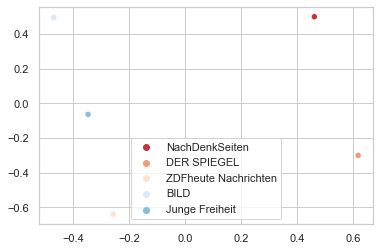

In [5]:
r=3

model = TruncatedSVD(n_components=r)
N_df_trunc = model.fit_transform(N_df.values)

sns.set(palette='RdBu', style='whitegrid')
sns.scatterplot(svd.components_[1], svd.components_[2], hue=['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit'])
plt.show()

In [253]:
topic = 'Ukrainekonflikt'
N = get_N_matrix(topic=topic)
N = N.reset_index().rename(columns={'index':'phrase'})
N['n_gram'] = N['phrase'].apply(str.split).apply(len)

N['count'] = N[['NachDenkSeiten', 'DER SPIEGEL', 'ZDFheute Nachrichten', 'BILD', 'Junge Freiheit']].sum(axis=1)

monograms = N[N['n_gram'] == 1]
bigrams = N[N['n_gram'] == 2]
trigrams = N[N['n_gram'] == 3]


In [254]:
bigram_words = [word for bigram_sublist in bigrams['phrase'].apply(str.split).tolist() for word in bigram_sublist]
bigram_words = list(set(bigram_words))
print(len(bigram_words))

1311


In [255]:
trigram_words = [word for trigram_sublist in trigrams['phrase'].apply(str.split).tolist() for word in trigram_sublist]
bigram_words = list(set(trigram_words))
print(len(trigram_words))

873


In [256]:
monograms_in_bigrams = monograms[monograms['phrase'].isin(bigram_words)]
monograms_in_trigrams = monograms[monograms['phrase'].isin(trigram_words)]

In [257]:
bigrams_in_trigrams_words = list(set([bigram_word for bigram_word in bigram_words if bigram_word in trigram_words]))
bigrams_in_trigrams_mask = bigrams['phrase'].apply(lambda bigram: True if bigram.split()[0] in bigrams_in_trigrams_words or bigram.split()[1] in bigrams_in_trigrams_words else False)
bigrams_in_trigrams = bigrams[bigrams_in_trigrams_mask]
print(bigrams_in_trigrams)

                  phrase  NachDenkSeiten  DER SPIEGEL  ZDFheute Nachrichten  \
6            abend abend               0            0                    38   
7             abend herr               0            0                    41   
8         abend herzlich               0            0                    23   
9            abend schön               0            0                    26   
20        abgeben freuen              97            0                     0   
...                  ...             ...          ...                   ...   
9893  zweitgrößten stadt               0            1                    11   
9932              öl gas               3            1                    80   
9933            öl kohle               0            0                    28   
9934         öl russland               0            1                     9   
9947    überfall ukraine               0            3                    21   

      BILD  Junge Freiheit  n_gram  count  
6      

In [258]:
threshold = 0.7
monograms_in_bigrams_above_threshold = list(set([monogram['phrase'] for _, monogram in monograms_in_bigrams.iterrows() for _, bigram in bigrams.iterrows() if monogram['phrase'] in bigram['phrase'].split() and bigram['count'] > threshold*monogram['count']]))
monograms_in_trigrams_above_threshold = list(set([monogram['phrase'] for _, monogram in monograms_in_trigrams.iterrows() for _, trigram in trigrams.iterrows() if monogram['phrase'] in trigram['phrase'].split() and trigram['count'] > threshold*monogram['count']]))
bigrams_in_trigrams_above_threshold = list(set([bigram['phrase'] for _, bigram in bigrams_in_trigrams.iterrows() for _, trigram in trigrams.iterrows() if (bigram['phrase'] in " ".join(trigram['phrase'].split()[:2]) or bigram['phrase'] in " ".join(trigram['phrase'].split()[-2:])) and trigram['count'] > threshold*bigram['count']]))

In [259]:
print(monograms_in_bigrams_above_threshold)
print(monograms_in_trigrams_above_threshold)
print(bigrams_in_trigrams_above_threshold)

['ursula', 'york', 'joe', 'mario', 'weiterverbreitung', 'times', 'abonnieren', 'olaf', 'petersburg', 'annalena', 'ronzheimer', 'weltmeistertitel', 'notre', 'rändern', 'bauernebel', 'aktionsbündnis', 'vereinigen', 'gerhard', 'leserinnen', 'meinungen', 'walter', 'watch', 'zweitgrößten', 'andrej', 'pen', 'sievers', 'nothilfe', 'kommissionspräsidenten', 'nord', 'baerbock', 'ost', 'gratis', 'bewertung', 'rights', 'herren', 'governor', 'angela', 'biden', 'klicken', 'potthoff', 'thiede', 'baltisch', 'prengel', 'habeck', 'damen', 'stream', 'pohl', 'usual', 'vereinen', 'felix', 'highlight', 'wladimir', 'inhalte', 'melik', 'zuschauerinnen', 'le', 'bürgerinnen', 'köpfe', 'tiede', 'hellen', 'audio', 'lambsdorff', 'sonntags', 'human', 'soundcloud', 'katastrophenhilfe', 'itunes', 'new']
['weiterverbreitung', 'times', 'abonnieren', 'weltmeistertitel', 'notre', 'rändern', 'aktionsbündnis', 'watch', 'walter', 'leserinnen', 'zweitgrößten', 'nothilfe', 'gratis', 'rights', 'bewertung', 'governor', 'klicke

In [248]:
n_grams_above_threshold = monograms_in_bigrams_above_threshold.append(monograms_in_trigrams_above_threshold).append(bigrams_in_trigrams_above_threshold)
n_grams_above_threshold

AttributeError: 'NoneType' object has no attribute 'append'

In [269]:
n_grams_above_threshold = list(set(np.append(np.append(monograms_in_bigrams_above_threshold, monograms_in_trigrams_above_threshold), bigrams_in_trigrams_above_threshold)))

In [282]:
N.drop(N[N['phrase'].isin(n_grams_above_threshold)].index, inplace = True)

In [283]:
N['phrase'].isin(n_grams_above_threshold).sum()

0

In [286]:
N.set_index('phrase').drop(columns=['n_gram', 'count'])

,NachDenkSeiten,DER SPIEGEL,ZDFheute Nachrichten,BILD,Junge Freiheit
phrase,,,,,
aartal,0,0,11,46,0
abbauen,4,3,17,40,0
abbrechen,6,1,21,67,0
abbringen,1,2,11,16,0
abdrehen,1,1,5,56,1
...,...,...,...,...,...
überzeugung,3,2,44,64,0
überziehen,3,1,2,25,0
üblich,15,3,14,85,1
